In [5]:
# Most basic stuff for EDA.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Core packages for text processing.

import string
import re

# Libraries for text preprocessing.

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Loading some sklearn packaces for modelling.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score

# Some packages for word clouds and NER.

#from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from PIL import Image
import spacy
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.5/en_core_web_sm-2.2.5.tar.gz
import en_core_web_sm

# Core packages for general use throughout the notebook.

import random
import warnings
import time
import datetime

# For customizing our plots.

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# Loading pytorch packages.

import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

# Setting some options for general use.

stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')


#Setting seeds for consistent results.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

[nltk_data] Downloading package stopwords to C:\Users\Tushar
[nltk_data]     Malankar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Tushar
[nltk_data]     Malankar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Tushar Malankar\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\Tushar
[nltk_data]     Malankar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


     ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.0 MB 2.0 MB/s eta 0:00:06
      --------------------------------------- 0.2/12.0 MB 3.5 MB/s eta 0:00:04
     - -------------------------------------- 0.4/12.0 MB 3.3 MB/s eta 0:00:04
     - -------------------------------------- 0.6/12.0 MB 3.7 MB/s eta 0:00:04
     -- ------------------------------------- 0.9/12.0 MB 4.0 MB/s eta 0:00:03
     --- ------------------------------------ 1.2/12.0 MB 4.7 MB/s eta 0:00:03
     ---- ----------------------------------- 1.4/12.0 MB 4.6 MB/s eta 0:00:03
     ----- ---------------------------------- 1.7/12.0 MB 5.0 MB/s eta 0:00:03
     ------ --------------------------------- 2.1/12.0 MB 5.3 MB/s eta 0:00:02
     -------- ------------------------------- 2.4/12.0 MB 5.5 MB/s eta 0:00:02
     --------- ------------------------------ 2.8/12.0 MB 5.8 MB/s eta 0:00:02
     ---------- ----------------------------- 3.2/12.0 MB 5

C:\Users\Tushar Malankar\anaconda3\Lib\site-packages\spacy\util.py:918: UserWarning: [W094] Model 'en_core_web_sm' (2.2.5) specifies an under-constrained spaCy version requirement: >=2.2.2. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.8.4,<3.9.0
  warnings.warn(warn_msg)


In [9]:
from wordcloud import WordCloud, STOPWORDS

In [7]:
!pip install wordcloud

   ---------------------------------------- 0.0/301.2 kB ? eta -:--:--
   ------------------- -------------------- 143.4/301.2 kB 2.8 MB/s eta 0:00:01
   ---------------------------------------- 301.2/301.2 kB 3.7 MB/s eta 0:00:00


In [13]:
# Loading the train and test data for visualization & exploration.

trainv = pd.read_csv('train.csv')
testv = pd.read_csv('test.csv')

In [15]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Applying helper functions

trainv['text_clean'] = trainv['text'].apply(lambda x: remove_URL(x))
trainv['text_clean'] = trainv['text_clean'].apply(lambda x: remove_emoji(x))
trainv['text_clean'] = trainv['text_clean'].apply(lambda x: remove_html(x))
trainv['text_clean'] = trainv['text_clean'].apply(lambda x: remove_punct(x))

In [17]:
# Tokenizing the tweet base texts.

trainv['tokenized'] = trainv['text_clean'].apply(word_tokenize)

trainv.head()

,id,keyword,location,text,target,text_clean,tokenized
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala..."


In [19]:
# Lower casing clean text.

trainv['lower'] = trainv['tokenized'].apply(
    lambda x: [word.lower() for word in x])

trainv.head()

,id,keyword,location,text,target,text_clean,tokenized,lower
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala..."


In [21]:
# Removing stopwords.

trainv['stopwords_removed'] = trainv['lower'].apply(
    lambda x: [word for word in x if word not in stop])

trainv.head()

,id,keyword,location,text,target,text_clean,tokenized,lower,stopwords_removed
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi..."


In [23]:

trainv['pos_tags'] = trainv['stopwords_removed'].apply(nltk.tag.pos_tag)

trainv.head()


,id,keyword,location,text,target,text_clean,tokenized,lower,stopwords_removed,pos_tags
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[(13000, CD), (people, NNS), (receive, JJ), (w..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N..."


In [25]:
# Converting part of speeches to wordnet format.

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


trainv['wordnet_pos'] = trainv['pos_tags'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

trainv.head()

,id,keyword,location,text,target,text_clean,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),...","[(deeds, n), (reason, n), (earthquake, n), (ma..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J...","[(forest, a), (fire, n), (near, n), (la, a), (..."
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)...","[(residents, n), (asked, v), (shelter, a), (pl..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[(13000, CD), (people, NNS), (receive, JJ), (w...","[(13000, n), (people, n), (receive, a), (wildf..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N...","[(got, v), (sent, a), (photo, n), (ruby, n), (..."


In [27]:
# Applying word lemmatizer.

wnl = WordNetLemmatizer()

trainv['lemmatized'] = trainv['wordnet_pos'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

trainv['lemmatized'] = trainv['lemmatized'].apply(
    lambda x: [word for word in x if word not in stop])

trainv['lemma_str'] = [' '.join(map(str, l)) for l in trainv['lemmatized']]

trainv.head()

,id,keyword,location,text,target,text_clean,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos,lemmatized,lemma_str
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[(deeds, NNS), (reason, NN), (earthquake, NN),...","[(deeds, n), (reason, n), (earthquake, n), (ma...","[deed, reason, earthquake, may, allah, forgive...",deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[(forest, JJS), (fire, NN), (near, IN), (la, J...","[(forest, a), (fire, n), (near, n), (la, a), (...","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[(residents, NNS), (asked, VBD), (shelter, JJ)...","[(residents, n), (asked, v), (shelter, a), (pl...","[resident, ask, shelter, place, notify, office...",resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...","[(13000, CD), (people, NNS), (receive, JJ), (w...","[(13000, n), (people, n), (receive, a), (wildf...","[13000, people, receive, wildfire, evacuation,...",13000 people receive wildfire evacuation order...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[(got, VBD), (sent, JJ), (photo, NN), (ruby, N...","[(got, v), (sent, a), (photo, n), (ruby, n), (...","[get, sent, photo, ruby, alaska, smoke, wildfi...",get sent photo ruby alaska smoke wildfires pou...


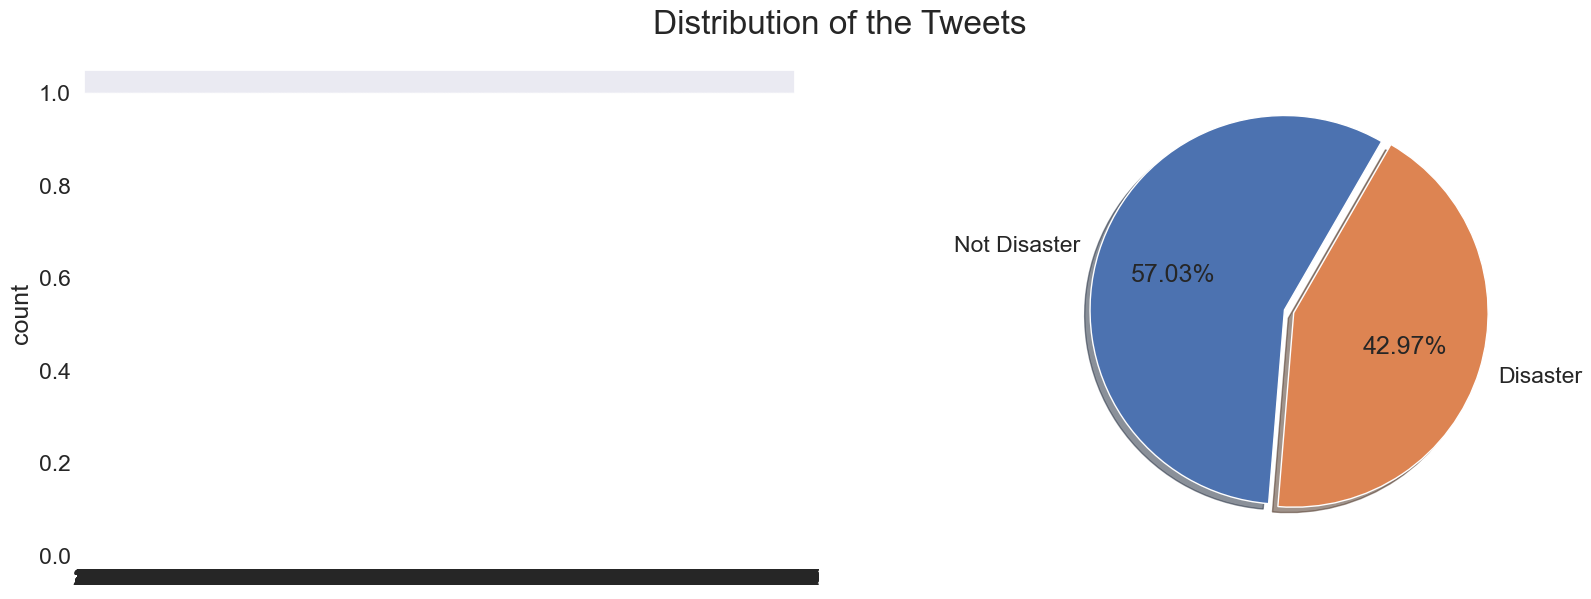

In [29]:
# Displaying target distribution.

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(trainv['target'], ax=axes[0])
axes[1].pie(trainv['target'].value_counts(),
            labels=['Not Disaster', 'Disaster'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

In [7]:
# Loading the data for modelling.

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(f'Number of training tweets: {train.shape[0]}\n')
print(f'Number of training tweets: {test.shape[0]}\n')

display(train.sample(10))

Number of training tweets: 7613

Number of training tweets: 3263



,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0
5559,7934,rainstorm,NaN,@Calum5SOS you look like you got caught in a r...,0
1765,2538,collision,NaN,my favorite lady came to our volunteer meeting...,1
1817,2611,crashed,NaN,@brianroemmele UX fail of EMV - people want to...,1
6810,9756,tragedy,"Los Angeles, CA",Can't find my ariana grande shirt this is a f...,0
4398,6254,hijacking,"Athens,Greece",The Murderous Story Of AmericaÛªs First Hijac...,1


In [9]:
labels = train['target'].values
idx = len(labels)
combined = pd.concat([train, test])
combined = combined.text.values

In [11]:
# Tokenizing the combined text data using bert tokenizer.

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

In [13]:
# Print the original tweet.

print(' Original: ', combined[0])

# Print the tweet split into tokens.

print('Tokenized: ', tokenizer.tokenize(combined[0]))

# Print the sentence mapped to token ID's.

print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(combined[0])))

 Original:  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Tokenized:  ['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', '#', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']
Token IDs:  [2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035]


In [15]:
max_len = 0

# For every sentence...

for text in combined:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    
    input_ids = tokenizer.encode(text, add_special_tokens=True)

    # Update the maximum sentence length.
    
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  84


In [16]:
# Making list of sentence lenghts:

token_lens = []

for text in combined:
    tokens = tokenizer.encode(text, max_length = 512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [19]:
# Splitting the train test data after tokenizing.

train= combined[:idx]
test = combined[idx:]
train.shape

(7613,)

In [21]:
def tokenize_map(sentence,labs='None'):
    
    """A function for tokenize all of the sentences and map the tokens to their word IDs."""
    
    global labels
    
    input_ids = []
    attention_masks = []

    # For every sentence...
    
    for text in sentence:
        #   "encode_plus" will:
        
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        
        encoded_dict = tokenizer.encode_plus(
                            text,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            truncation='longest_first', # Activate and control truncation
                            max_length = 84,           # Max length according to our text data.
                            pad_to_max_length = True, # Pad & truncate all sentences.
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the id list. 
        
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    if labs is not 'None': # Setting this for using this definition for both train and test data so labels won't be a problem in our outputs.
        labels = torch.tensor(labels)
        return input_ids, attention_masks, labels
    else:
        return input_ids, attention_masks

In [23]:
# Tokenizing all of the train test sentences and mapping the tokens to their word IDs.

input_ids, attention_masks, labels = tokenize_map(train, labels)
test_input_ids, test_attention_masks= tokenize_map(test)

In [25]:
# Combine the training inputs into a TensorDataset.

dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.

# Calculate the number of samples to include in each set.

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

6,090 training samples
1,523 validation samples


In [27]:
# The DataLoader needs to know our batch size for training, so we specify it here. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [29]:
prediction_data = TensorDataset(test_input_ids, test_attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [31]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained(
    'bert-large-uncased', # Use the 124-layer, 1024-hidden, 16-heads, 340M parameters BERT model with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification. You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to GPU
model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1

In [33]:
# Get all of the model's parameters as a list of tuples:

params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].size()))))

The BERT model has 393 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 1024)
bert.embeddings.position_embeddings.weight               (512, 1024)
bert.embeddings.token_type_embeddings.weight               (2, 1024)
bert.embeddings.LayerNorm.weight                             (1024,)
bert.embeddings.LayerNorm.bias                               (1024,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.query.bias               (1024,)
bert.encoder.layer.0.attention.self.key.weight          (1024, 1024)
bert.encoder.layer.0.attention.self.key.bias                 (1024,)
bert.encoder.layer.0.attention.self.value.weight        (1024, 1024)
bert.encoder.layer.0.attention.self.value.bias               (1024,)
bert.encoder.layer.0.attention.output.dense.weight      (1024, 1024)
bert.encoder.layer.0.attention.output.dense.bias             (

In [35]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch).

# The 'W' stands for 'Weight Decay fix' probably...

optimizer = AdamW(model.parameters(),
                  lr = 6e-6, # args.learning_rate
                  eps = 1e-8 # args.adam_epsilon
                )

In [37]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 

# We chose to run for 3, but we'll see later that this may be over-fitting the training data.

epochs = 3

# Total number of training steps is [number of batches] x [number of epochs] (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [39]:
def flat_accuracy(preds, labels):
    
    """A function for calculating accuracy scores"""
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    return accuracy_score(labels_flat, pred_flat)

def flat_f1(preds, labels):
    
    """A function for calculating f1 scores"""
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    return f1_score(labels_flat, pred_flat)

In [41]:
def format_time(elapsed):    
    
    """A function that takes a time in seconds and returns a string hh:mm:ss"""
    
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [45]:
import torch
import time

# Tracking training statistics
training_stats = []

# Measure the total training time for the whole run
total_t0 = time.time()

# Loop over epochs
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    print('')
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 50 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Move batch to the correct device
        b_input_ids = batch[0].to(device).to(torch.int64)
        b_input_mask = batch[1].to(device).to(torch.int64)
        b_labels = batch[2].to(device).to(torch.int64)

        # Clear previously accumulated gradients
        model.zero_grad()

        # Forward pass - Explicitly get loss and logits
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)

        loss = outputs.loss  # Extract loss
        logits = outputs.logits  # Extract logits

        # Ensure loss is valid before calling .item()
        if loss is not None:
            total_train_loss += loss.item()
        else:
            print("Warning: Loss is None for this batch!")

        # Backward pass
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print('')
    print('  Average training loss: {0:.2f}'.format(avg_train_loss))
    print('  Training epoch took: {:}'.format(training_time))

    # ========================================
    #               Validation
    # ========================================
    print('')
    print('Running Validation...')

    t0 = time.time()
    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    total_eval_f1 = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels)

            loss = outputs.loss  # Extract loss
            logits = outputs.logits  # Extract logits

        if loss is not None:
            total_eval_loss += loss.item()
        else:
            print("Warning: Validation loss is None!")

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        total_eval_f1 += flat_f1(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    avg_val_f1 = total_eval_f1 / len(validation_dataloader)
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)

    print('  Accuracy: {0:.2f}'.format(avg_val_accuracy))
    print('  F1: {0:.2f}'.format(avg_val_f1))
    print('  Validation Loss: {0:.2f}'.format(avg_val_loss))
    print('  Validation took: {:}'.format(validation_time))

    # Store statistics
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Val_F1': avg_val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print('')
print('Training complete!')
print('Total training took {:} (h:mm:ss)'.format(format_time(time.time()-total_t0)))



======== Epoch 1 / 3 ========
Training...
  Batch    50  of    191.    Elapsed: 0:03:23.
  Batch   100  of    191.    Elapsed: 0:06:46.
  Batch   150  of    191.    Elapsed: 0:10:23.

  Average training loss: 0.49
  Training epoch took: 0:13:07

Running Validation...
  Accuracy: 0.83
  F1: 0.78
  Validation Loss: 0.41
  Validation took: 0:00:14

======== Epoch 2 / 3 ========
Training...
  Batch    50  of    191.    Elapsed: 0:03:33.
  Batch   100  of    191.    Elapsed: 0:08:06.
  Batch   150  of    191.    Elapsed: 0:13:01.

  Average training loss: 0.36
  Training epoch took: 0:16:56

Running Validation...
  Accuracy: 0.82
  F1: 0.78
  Validation Loss: 0.44
  Validation took: 0:00:50

======== Epoch 3 / 3 ========
Training...
  Batch    50  of    191.    Elapsed: 0:04:52.
  Batch   100  of    191.    Elapsed: 0:09:44.
  Batch   150  of    191.    Elapsed: 0:14:36.

  Average training loss: 0.31
  Training epoch took: 0:18:30

Running Validation...
  Accuracy: 0.84
  F1: 0.79
  Valid

In [49]:
# Prediction on test set:

print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

# Put model in evaluation mode:

model.eval()

# Tracking variables :

predictions = []

# Predict:

for batch in prediction_dataloader:
    
  # Add batch to GPU

  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader:
    
  b_input_ids, b_input_mask, = batch
  
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction:

  with torch.no_grad():
      # Forward pass, calculate logit predictions:
    
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU:
    
  logits = logits.detach().cpu().numpy()
 
  
  # Store predictions and true labels:
    
  predictions.append(logits)


print('    DONE.')

Predicting labels for 3,263 test sentences...
    DONE.


In [51]:
# Getting list of predictions and then choosing the target value with using argmax on probabilities.

flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

In [53]:
import pandas as pd

# Load the existing submission file
submission = pd.read_csv('sample_submission.csv')

# Create a new DataFrame with the first column unchanged and new predictions
new_submission = pd.DataFrame({
    submission.columns[0]: submission.iloc[:, 0],  # Copy the first column
    'target': flat_predictions  # Add new prediction values
})

# Save to a new CSV file
new_submission.to_csv('new_submission.csv', index=False)

# Display the first 10 rows
print(new_submission.head(10))


   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1
5  12       1
6  21       0
7  22       0
8  27       0
9  29       0
